## Discovering my interests in Hacker News with NLP
# Part III: Rock'n'Roll, Topic modelling and analysis

In [50]:
import spacy
import gensim
import pandas as pd
from typing import Union, Tuple, List
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re

## 1. Load scraped content (from "02-HN-Favs-Scrapping-Content")

In [51]:
df = pd.read_pickle('hn_favs_scrapped.pickle')
scrapped_urls = df.to_dict('records')

## 2. HTML -> Features

We use a simple class to store the relevant information within a web page.

The first class, `ScrapedWeb` is just a container class ("structure").

The second class adds methods to obtain the information.

The method `wholeWeighted` returns the content weighted according to its relevant (Array of sentences). The title of the web page has a default weight of 10. Headings are weighted by 4. 

In [52]:
class ScrapedWeb(object):
    """
    Scraped web (POJO)
    """
    def __init__(self, url: str, title: str, description: str, headings: List[str], contents: List[str], dom: BeautifulSoup):
        
        self.url = url
        self.title = title
        self.description = description
        self.headings = headings
        self.contents = contents
        self.dom = dom

    def __str__(self):
        
        return f"'{self.title}' @ {self.url}"

    def __repr__(self):
        
        return f"{self.title}"

In [53]:
class ScrapedWebVitamined(ScrapedWeb):
    """
    Scraped web with vitamines and steroids (augmented and functions)
    """
    
    def wordsWeighted(self, wTitle=10, wHeadings=4):
        """
        Get all content as list of words.
        Frequency matters, so the words in "title" or "headings" worth more than in the rest of contents
        """
        words = []
        # Title
        if self.title:
            words += [x.strip().lower() for x in self.title.replace('\n', ' ').replace('\t', ' ').split(" ")] * wTitle
        # Headings
        words += [x.strip().lower() for y in self.headings for x in y.replace('\n', ' ').replace('\t', ' ').split(" ") if x != ''] * wHeadings
        # Content
        words += [x.strip().lower() for y in self.contents for x in y.replace('\n', ' ').replace('\t', ' ').split(" ") if x != '']
        return words

    def whole(self) -> List[str]:
        """
        Whole document by multiply sections for a weight factor (relevance)
        """
        return self.wholeWeighted(wTitle=1, wHeading=1)
    
    def wholeWeighted(self, wTitle=10, wHeading=4) -> List[str]:
        """
        Get whole webpage a list of strings
        """
        ret = []
        # Title
        if self.title:
            ret += [self.title] * wTitle
        # Headings
        ret += self.headings * wHeading
        # Content
        ret += [y.strip().lower() for x in self.contents for y in x.replace('\t', ' ').split('\n') if y.strip() != '']
        return ret
    
    def save(self, path: str):
        """
        Save whole info in "path"
        """
        with open(path, 'w') as w:
            if self.title:
                w.write(self.title + '\n---\n\n')
            for x in self.headings:
                w.write(f"- {x}\n\n")
            for x in self.contents:
                w.write(f"{x}\n")

In [54]:
def getDescription(dom: BeautifulSoup) -> Union[str, None]:
    """
    Get description
    """
    # 1. meta with property
    obj = dom.find('meta', property='description')
    if obj is not None:
        return obj.attrs.get('content')
    # 2. old HTML description
    obj = dom.find('meta', itemprop='description')
    if obj is not None:
        return obj.attrs.get('content')
    # 3. meta desc with OG
    obj = dom.find('meta', property='og:description')
    if obj is not None:
        return obj.attrs.get('content')
    # Not found
    return None

The following method, `html2ScrapedWeb`, parses the HTML code using `HTML5LIB` parsers and generate a `ScrapedWebVitamined` instance. The focus is on the HTML tags that usually contribute content. We ignore tags such as `script`, `nav`, `footer`, etc.

In [55]:
def html2ScrapedWeb(url: str, html: str) -> ScrapedWebVitamined:
    """
    Parse HTML using BS4 HTML5Lib parser and get <body> content without
    <nav>, <script>, <footer>
    It's focus on content
    """
    dom = BeautifulSoup(html, 'html5lib')
    # 1. Get title
    title = dom.title.string if dom.title else None
    # 2. Get description
    desc = getDescription(dom)
    # 3. Remove undesired elements
    dropTags = ["script", "head", "nav", "footer"]
    for tag in dropTags:
        for elem in dom.find_all(tag):
            elem.decompose()
    # 4. Headings
    headings = [x.getText() for idx in range(6) for x in dom.find_all(f'h{idx+1}') if x]
    # 5. Content
    s = set()
    for x in dom.find_all(["p", "td", "li", "a"]):
        s.add(x.getText().strip())
    contents = list(s)
    return ScrapedWebVitamined(url, title, desc, headings, contents, dom)

We process all the pages and obtain the weighted contents.

In [81]:
docs_ww = []
idx = 1
for item in tqdm(scrapped_urls):
    try:
        sw = html2ScrapedWeb(item['url'], item['content'])
        idx += 1
    except Exception as err:
        print(f'Error: {err}')
        continue
    docs_ww.append([x.replace('\t', ' ').replace('\n', ' ') for x in sw.wholeWeighted()])

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. Pre-processing words

Now it's time to use spaCy to pre-process the information using its great NLP pipeline.

We use the large english model (around 800 MB)

In [57]:
nlp = spacy.load('en_core_web_lg')

We add custom stop words. These words are very common in the major topic: "IT content". If we not remove them, the modelling performance will be not accurate. The major of stop word are call-to-actions inside GitHub.

In [110]:
CUSTOM_STOP_WORDS = {'commit', 'github', 'pdf', 'download', 'desktop', '$', '|', '\\', '/', '#'}
nlp.Defaults.stop_words |= CUSTOM_STOP_WORDS

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We add two additional pipeline steps. `lemmatizer` to get the "root" of the words and `remove_stopwords` to remove stops words and get the list of plain token. Ready for gensim step. These functions are based in the work of [Jonathan Keller in "Building a Topic Modeling Pipeline with spaCy and Gensim"](https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619)

In [111]:
def lemmatizer(doc):
    """
    This takes in a doc of tokens from the NER and lemmatizes them. 
    Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    """
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    """
    This will remove stopwords and punctuation.
    Use token.text to return strings, which we'll need for Gensim.
    """
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.text.strip() != '' and token.is_digit != True]
    return doc

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We add the two custom steps defined above

In [112]:
if 'lemmatizer' in nlp.pipe_names:
    nlp.remove_pipe('lemmatizer')
if 'stopwords' in nlp.pipe_names:
    nlp.remove_pipe('stopwords')

nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We pre-processing all docs with NLP. Just before, we removed possible emojis. 

In [113]:
docs = []
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
for item in tqdm(docs_ww):
    docs.append(nlp(emoji_pattern.sub(r'', '.'.join(item))))

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3. Create LDA model

For the topic modelling we use the [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This technique has a good performance. We use the implementation included in Gensim library.

In [64]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel

Time to translate from the "word" world to "numeric" world

In [114]:
words = corpora.Dictionary(docs)
print(f'Words in corpora: {len(words)}')

Words in corpora: 31143


/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We create a bag-of-words for each scraped web

In [115]:
corpus = [words.doc2bow(doc) for doc in docs]

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Determining the "best" number of topics

One of the requisites of LDA is the number of topics. However, one of the main questions to answered in this study is in how many topics can we classify our favorites.

So then we explore the model performance using different number and topics. For the model evaluation, we use the __coherence__ value.

In [118]:
perplexities = []
coherence = []
num_topics = [3,4, 10, 20] + list(range(5, 75, 10))
for nt in tqdm(num_topics):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=nt, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    perplexities.append(lda_model.log_perplexity(corpus))
    coherence_lda_model = CoherenceModel(model=lda_model, texts=docs, dictionary=words, coherence='c_v')
    print(f"Num: {nt} - Per: {lda_model.log_perplexity(corpus)} - Coh: {coherence_lda_model.get_coherence()}")
    coherence.append(coherence_lda_model.get_coherence())

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num: 3 - Per: -8.706249485896016 - Coh: 0.406049454903293
Num: 4 - Per: -8.649301305774259 - Coh: 0.38374936996538217
Num: 10 - Per: -8.4581701083516 - Coh: 0.38268112438434737
Num: 20 - Per: -8.392244195846711 - Coh: 0.4052678081302683
Num: 5 - Per: -8.608912621949576 - Coh: 0.37768870173922114
Num: 15 - Per: -8.388397620462364 - Coh: 0.42887546867104637
Num: 25 - Per: -8.415253337960689 - Coh: 0.4026790278006228
Num: 35 - Per: -8.929328926337282 - Coh: 0.3900338394877201
Num: 45 - Per: -9.720797298409657 - Coh: 0.38761121529330567
Num: 55 - Per: -10.44214094061128 - Coh: 0.39938378497375415
Num: 65 - Per: -10.901780268370514 - Coh: 0.41418189089328733



We plot the coherence metric

In [68]:
import matplotlib.pyplot as plt

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


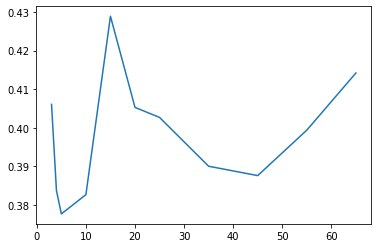

In [119]:
plt.plot(pd.DataFrame(coherence, index=num_topics).sort_index())

In our case we achieve a good performance with `num_topics` equal to __15__. 

We re-create the model with that value.

In [120]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=15, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We print the main keywords in the topics

In [121]:
lda_model.print_topics(num_topics=15, num_words=10)

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"de" + 0.007*"use" + 0.007*"Mozilla" + 0.006*"join" + 0.005*"Firefox" + 0.005*"file" + 0.004*"parte" + 0.004*"forma" + 0.004*"change" + 0.004*"Media"'),
 (1,
  '0.035*"add" + 0.033*"support" + 0.009*"driver" + 0.007*"use" + 0.006*"new" + 0.005*"device" + 0.005*"commit.add" + 0.005*"file" + 0.003*"proxy" + 0.003*"system"'),
 (2,
  '0.009*"use" + 0.008*"model" + 0.007*"browser" + 0.007*"git" + 0.006*"client" + 0.006*"financial" + 0.005*"template" + 0.004*"startup" + 0.004*"user" + 0.004*"fuzzy"'),
 (3,
  '0.011*"use" + 0.007*"system" + 0.006*"open" + 0.006*"source" + 0.004*"graph" + 0.004*"run" + 0.004*"create" + 0.004*"user" + 0.004*"network" + 0.004*"device"'),
 (4,
  '0.009*"use" + 0.008*"marketing" + 0.008*"email" + 0.008*"content" + 0.006*"product" + 0.006*"ad" + 0.006*"user" + 0.005*"tool" + 0.005*"guide" + 0.005*"facebook"'),
 (5,
  '0.012*"use" + 0.011*"list" + 0.008*"|" + 0.006*"app" + 0.006*"end" + 0.006*"generate" + 0.005*"network" + 0.005*"weight" + 0.005*"like"

But it's better to explore the topics using `PyLDAvis` library. 

With it we can see how the topics are distributed: if they are very large, if they are far from each other, if they are coupled, etc.

It provides a lot of information in a simple and visual way.

In [73]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [122]:
pyLDAvis.gensim.prepare(lda_model, corpus, words)

/home/chema/projects/articles/hn-self-topics-nlp/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.108571 -0.024316       1        1  18.183886
3      0.078067 -0.046319       2        1  12.597104
7      0.088336 -0.034560       3        1   8.325457
4      0.078546  0.030713       4        1   7.948973
5      0.088239  0.027500       5        1   7.690801
9      0.032969  0.079878       6        1   6.934658
6      0.063167 -0.104047       7        1   6.608631
1     -0.066881 -0.097828       8        1   6.115636
2      0.009617  0.051726       9        1   5.643451
0     -0.014742  0.047118      10        1   5.405213
12    -0.001989  0.082794      11        1   4.661440
8     -0.120411  0.173908      12        1   4.535812
11    -0.104361 -0.010775      13        1   1.958689
10    -0.082850 -0.073932      14        1   1.861168
13    -0.156277 -0.101860      15        1   1.529080, topic_info=         Term        Freq        Total Category  logprob  loglift
33        add  720.000000   720.000000  Default  30.0000  30.0000
411   support  731.000000   731.000000  Default  29.0000  29.0000
1436   launch  481.000000   481.000000  Default  28.0000  28.0000
631     model  525.000000   525.000000  Default  27.0000  27.0000
6392      pod  190.000000   190.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
2055  release   12.899898   255.405977  Topic15  -5.4648   1.1949
507     build   12.950774   578.000457  Topic15  -5.4609   0.3821
762      find   12.355266   390.211186  Topic15  -5.5079   0.7279
444       use   13.464118  1827.237962  Topic15  -5.4220  -0.7300
2165    Model    9.387920    69.247979  Topic15  -5.7826   2.1822

[995 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.300435    $
0         2  0.036416    $
0         3  0.027312    $
0         4  0.141113    $
0         5  0.022760    $
...     ...       ...  ...
3330      1  0.019751    ®
3330      3  0.849305    ®
3330      6  0.039503    ®
3330     12  0.039503    ®
3330     13  0.039503    ®

[3765 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 4, 8, 5, 6, 10, 7, 2, 3, 1, 13, 9, 12, 11, 14])

I hope this study has been of your interest. Give a ⭐ on GitHub if you find it interesting and/or useful.